<style type="text/css">
#image {
  float:left;
  border-right:1px;
  width:145px;
  height:145px;
  margin-top:1px;
  margin-left:50px;
  padding:1px;
  background-color:#ffffff;
}
#subject {
  float:left;
  width:500px;
  border-radius: 10px; 
  height:130px;
  margin-top:6px;
  padding:1px;
  background-color:#b0bc04;
}
</style>

<div id="image">
<img src="https://www.imt-atlantique.fr/sites/default/files/ecole/IMT_Atlantique_logo.png" WIDTH=240 HEIGHT=240>
</div>
<div id="subject">
<CENTER>
</br>

<font size="5">TAF MCE - UE Computer Vision | Project : Visual tracking of video objects </font></br></div>

<CENTER>
P.-H. Conze <span style="color:blue">pierre-henri.conze@imt-atlantique.fr</span> - 
R. Fablet <span style="color:blue">ronan.fablet@imt-atlantique.fr</span> - 
A. Colin <span style="color:blue">acolin@groupcls.com</span>
<CENTER>
</CENTER>
</div> 

## Purpose of the project

Implement the methodology described in the article and apply it in the context of **visual tracking of video objects** within image sequences. Spefically, the targeted application consists in estimating for the whole sequence the location of a manually defined region of interest in the first image, called **reference image**. Development will be done in python language and can use functions from librairies such as openCV, scikit-image, scikit-learn, keras... 

In [1]:
import numpy as np
import cv2
from skimage import io
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import img_as_ubyte
import distutils.dir_util
from skimage.measure import regionprops
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel

## Data

In [38]:
name = 'cows' # name of the sequence : bag, bear, book, camel, rhino, swan
im_begin, im_end = 1, 104              # reference image (1) and last image (varies depending on the sequence)
output_folder = './our_results/'+name+'/' # result folder
output_baseline = './outputs_baseline/'+name+'/'

## Assessment

**DICE_assessment()** evaluates the overlap between the two masks while **db_eval_boundary()** quantifies the quality of the estimated contours. Each function returns a score between 0 (poor quality) and 100 (perfect quality).

**centroid_assessment()** comptes the Euclidean distance between groundtruth and estimated centroids.

In [33]:
def DICE_assessment(groundtruth, estimated, label=255):
    A = groundtruth == label
    B = estimated == label              
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0: 
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

In [34]:
def centroid_assessment(groundtruth,estimated):
    a = regionprops(groundtruth)
    b = regionprops(estimated)
    return np.linalg.norm(np.array(a[0].centroid)-np.array(b[0].centroid))

#  Baseline method

Let us consider a sequence of $N$ RGB images $\{I_{n}\}$ with $n\in \{1,\ldots,N\}$ where $I_{1}$ is the so-called reference image. Here, we estimate the long term motion between each image $I_{n}$ with $n \neq 1$ and the reference image $I_{1}$ by means of an optical flow estimator which processes the pairs $\{I_{n},I_{1}\}$ independently.

In this example, an openCV implementation of **Farnebäck's optical flow estimator** (G. Farnebäck, “Two-frame motion estimation based on polynomial expansion,” Image Analysis, pp. 363–370, 2003) is used.


In [35]:
def farneback(im1, im2):
    return cv2.calcOpticalFlowFarneback(im1, im2, None, pyr_scale=0.5, levels=3, winsize=7, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) # None

Once the optical flow fields have been estimated, the **propagate_mask()** function below can propagate the groundtruth segmentation mask from $I_{1}$ to $I_{n}$.

In [36]:
def propagate_mask(flow, img_current, mask_begin):
    new_mask = np.zeros(shape=img_current.shape[:2], dtype=np.uint8)
    for x in range(img_current.shape[0]):
        for y in range(img_current.shape[1]):
            x_, y_ = np.rint(x+flow[x,y,1]).astype(np.int), np.rint(y+flow[x,y,0]).astype(np.int)
            if (x_>=0) and (x_<img_current.shape[0]) and (y_>=0) and (y_<img_current.shape[1]):
                if mask_begin[x_,y_] > 0:
                    new_mask[x,y] = 255
    return new_mask

In [40]:
img_begin = io.imread('./baseline_sequence_train/'+name+'/%0*d.bmp'%(3,im_begin))
mask_begin = io.imread('./baseline_sequence_train/'+name+'/%0*d.png'%(3,im_begin))

dices_baseline, centroid_dist_baseline= [], []
for im in range(im_begin+1,im_end+1):
    print(im)
    img_current = io.imread('./baseline_sequence_train/'+name+'/%0*d.bmp'%(3,im))
    mask_current = io.imread('./baseline_sequence_train/'+name+'/%0*d.png'%(3,im))
    flow = farneback(img_as_ubyte(rgb2gray(img_current)), img_as_ubyte(rgb2gray(img_begin)))
    propagation = propagate_mask(flow, img_current, mask_begin)
    io.imsave(output_baseline+'prop-%0*d.png'%(3,im), propagation)
    dices_baseline.append(DICE_assessment(mask_current, propagation))
    centroid_dist_baseline.append(centroid_assessment(mask_current, propagation))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


## Evaluation on Pygoturn method

In [41]:
mask_begin = io.imread('./our_results/'+name+'/%d_GT.bmp'%(im_begin))
mask_predicted = io.imread('./our_results/'+name+'/%d_Pre.bmp'%(im_begin))


dices, centroid_dist= [], []
dices_delta, centroid_dist_delta = [], []
for im in range(im_begin+1,im_end+1):
    mask_current = io.imread('./our_results/'+name+'/%d_GT.bmp'%(im))
    mask_predicted = io.imread('./our_results/'+name+'/%d_Pre.bmp'%(im))
    
    mask_current_delta = io.imread('./our_results/'+name+'_delta'+'/%d_GT.bmp'%(im))
    mask_predicted_delta = io.imread('./our_results/'+name+'_delta'+'/%d_Pre.bmp'%(im))
    
    dices.append(DICE_assessment(mask_current, mask_predicted))
    centroid_dist.append(centroid_assessment(mask_current, mask_predicted))
    
    dices_delta.append(DICE_assessment(mask_current_delta, mask_predicted_delta))
    centroid_dist_delta.append(centroid_assessment(mask_current_delta, mask_predicted_delta))

## Result visualization


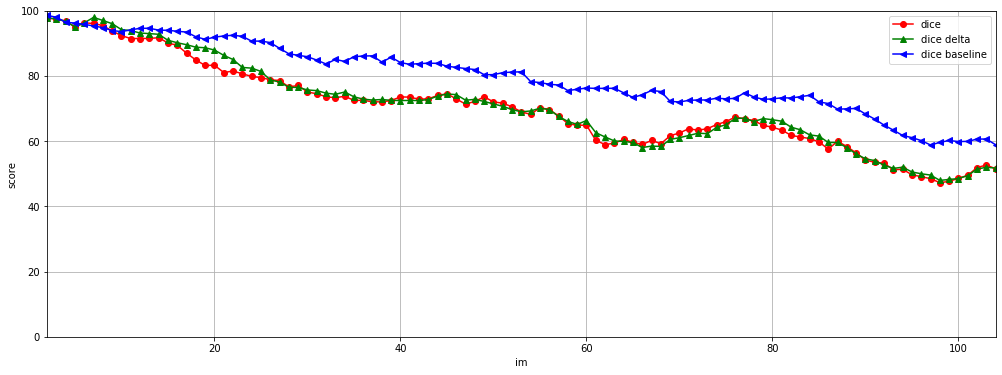

In [44]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,dices,marker='o',color='r')
plt.plot(x,dices_delta,marker='^',color='g')
plt.plot(x,dices_baseline,marker='<',color='b')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['dice', 'dice delta', 'dice baseline'])
plt.savefig(output_folder+'eval.png')
plt.show()

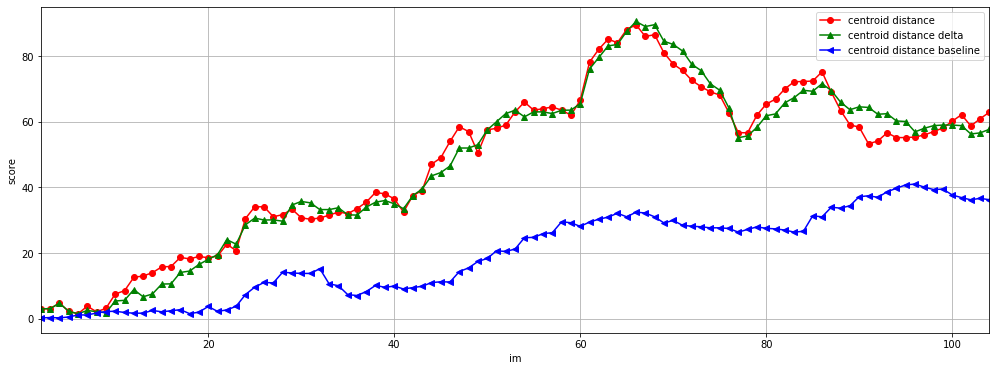

In [45]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,centroid_dist,marker='o',color='r')
plt.plot(x,centroid_dist_delta,marker='^',color='g')
plt.plot(x,centroid_dist_baseline,marker='<',color='b')
plt.xlim((im_begin+1,im_end))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['centroid distance','centroid distance delta', 'centroid distance baseline'])
plt.savefig(output_folder+'eval-centroid.png')
plt.show()

<Figure size 432x288 with 0 Axes>

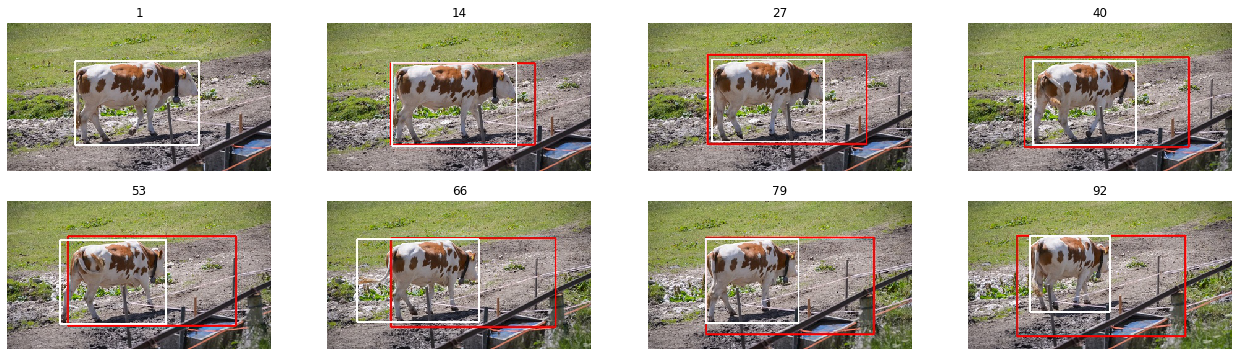

In [31]:
plt.figure()
plt.figure(figsize=(22, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    im = np.int(np.floor(i*(im_end/8)+im_begin-1))
    plt.imshow(io.imread('./our_results/'+name+'/%d.jpg'%(im+1)))
    plt.title('%i' %(im+1))
plt.show()

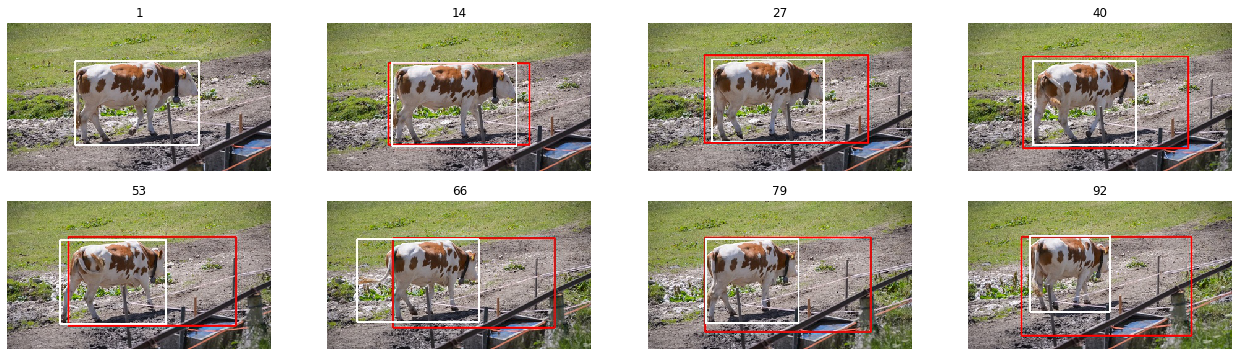

In [32]:
plt.figure(figsize=(22, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    im = np.int(np.floor(i*(im_end/8)+im_begin-1))
    plt.imshow(io.imread('./our_results/'+name+'_delta'+'/%d.jpg'%(im+1)))
    plt.title('%i' %(im+1))
plt.show()